# Practice Session 07: Connected components

*Introduction to Network Science* (2025/26), UPF

***Version 1***

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import statistics

# 1. The Star Wars graph

In [3]:
INPUT_GRAPH_FILENAME = "data/starwars/starwars.graphml"

# Read the graph in GraphML format
g_in = nx.read_graphml(INPUT_GRAPH_FILENAME)

# Re-label the nodes so they use the 'name' as label
g_relabeled = nx.relabel.relabel_nodes(g_in, dict(g_in.nodes(data='name')))

# Convert the graph to undirected
g = g_relabeled.to_undirected()

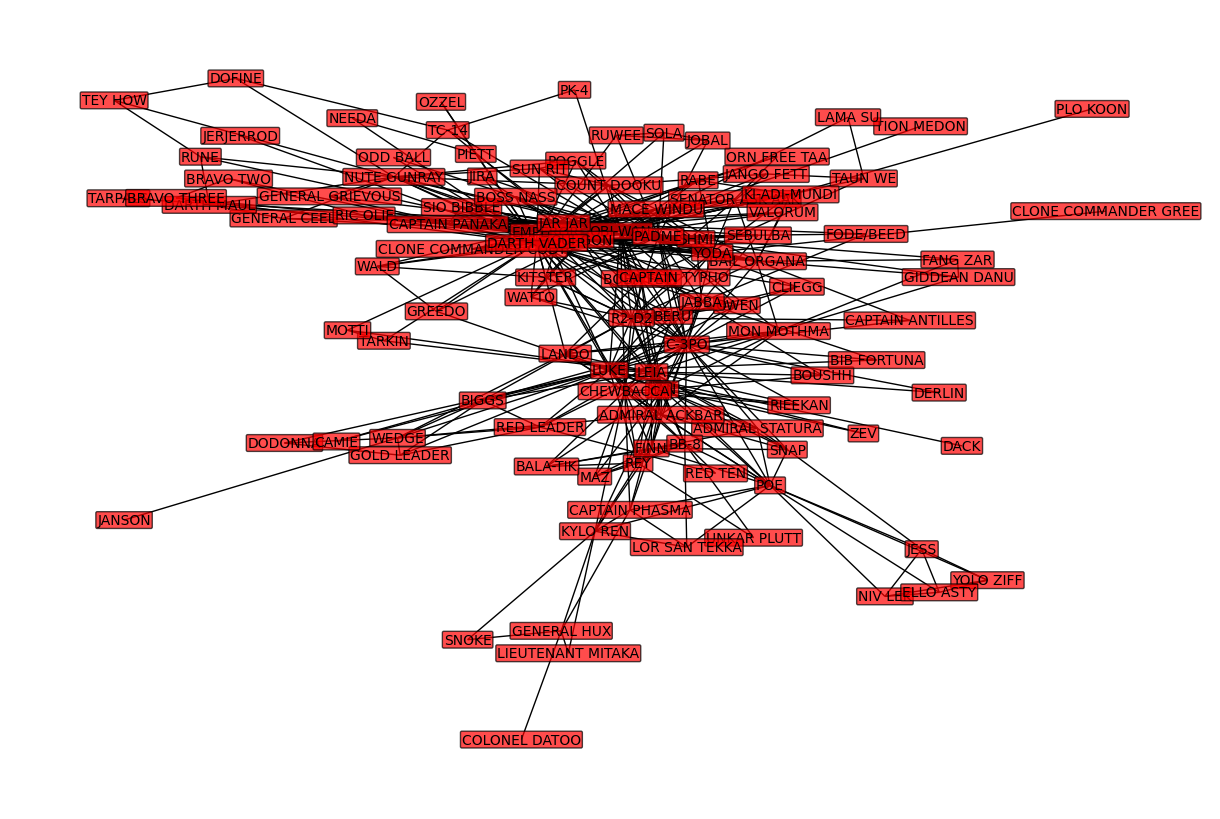

In [ ]:
def plot_graph(g):

    # Create a figure
    plt.figure(figsize=(12,8))

    # Layout the nodes using a spring model
    nx.draw_spring(
        g, 
        with_labels=True, font_size=10,     # Make labels, with label box defined below
        bbox=dict(facecolor="red", edgecolor='black', boxstyle='round,pad=0.1', alpha=0.7),
        node_size=0     # Hide nodes, leave only labels
    )

    # Display
    plt.show()

plot_graph(g)

In [5]:
print(nx.is_connected(g))

True


In [6]:
max_degree = max(dict(g.degree()).values())
avg_degree = statistics.mean(dict(g.degree()).values())
standard_dev_degree = statistics.stdev(dict(g.degree()).values())

print(f"Max degree: {max_degree}")
print(f"Mean degree: {round(avg_degree, 1):.2f}")
print(f"Standard deviation of degree: {round(standard_dev_degree, 1):.2f}")

Max degree: 52
Mean degree: 8.10
Standard deviation of degree: 8.70


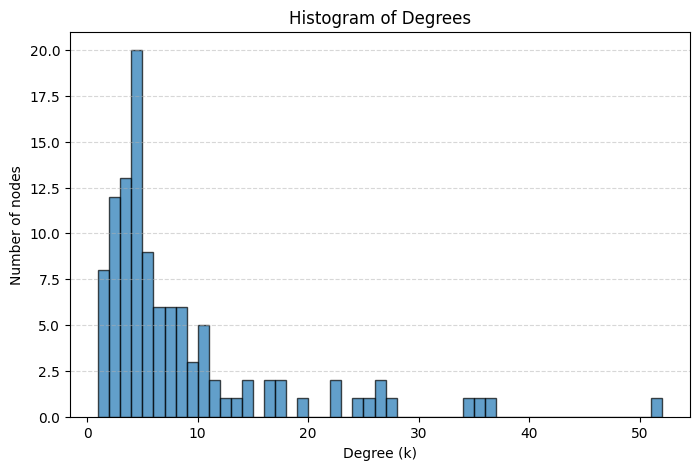

In [7]:
import matplotlib.pyplot as plt

degrees = [degree for node, degree in g.degree()] # get list of degrees

bin_width = 1 # found that 1 works just dine for this data
bins = range(min(degrees), max(degrees) + bin_width, bin_width) # make bins

plt.figure(figsize=(8,5))
plt.hist(degrees, bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel("Degree (k)")
plt.ylabel("Number of nodes")
plt.title("Histogram of Degrees")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


# 2. Remove a fraction of edges

In [9]:
def remove_edges_uniformly_at_random(g_in, p):
    if p < 0.0 or p > 1.0:
        raise ValueError

    g_out = g_in.copy()

    target_num_edges = int((1.0-p) * g_in.number_of_edges())

    while g_out.number_of_edges() > target_num_edges:

        # Remove one random edge
        edge = random.choice(list(g_out.edges()))

        if g_out.has_edge(edge[0], edge[1]):
            g_out.remove_edge(edge[0], edge[1])

    # Return the resulting graph
    return g_out

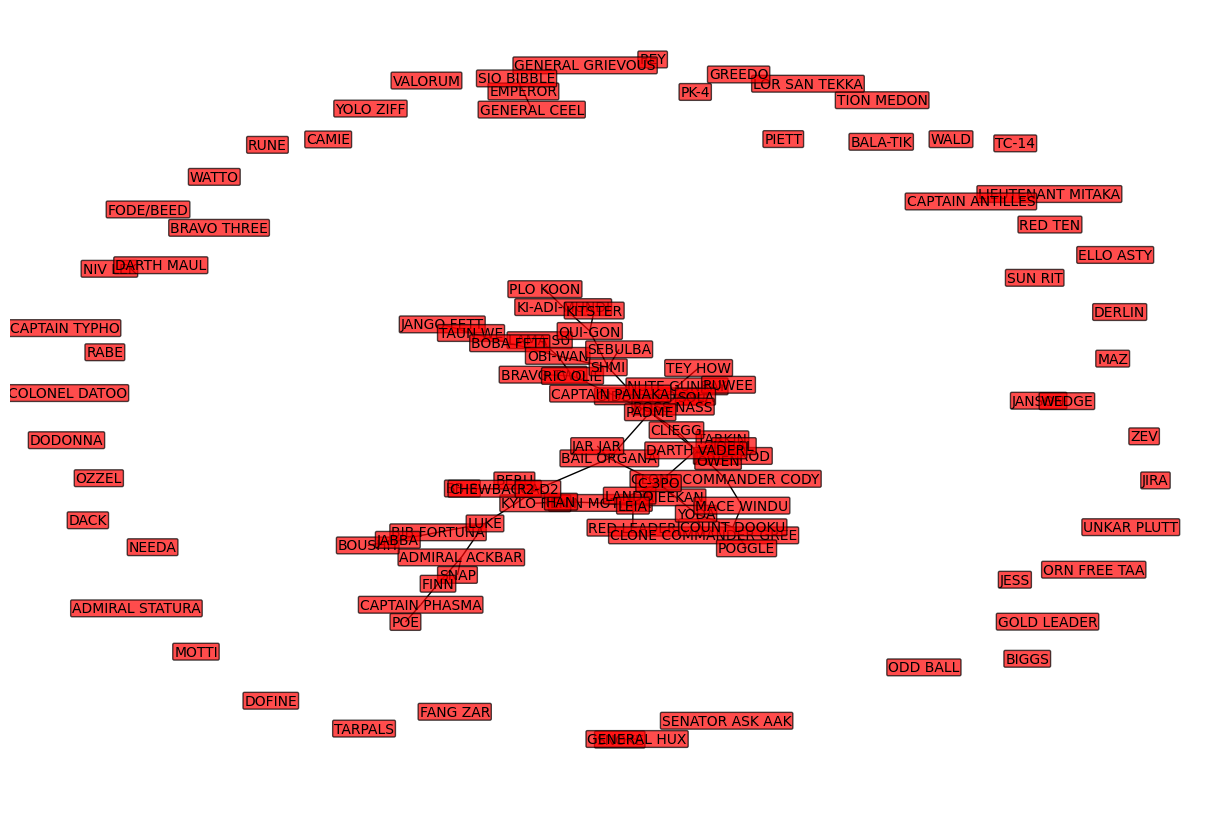

In [10]:
g15 = remove_edges_uniformly_at_random(g, 0.85)
plot_graph(g15)

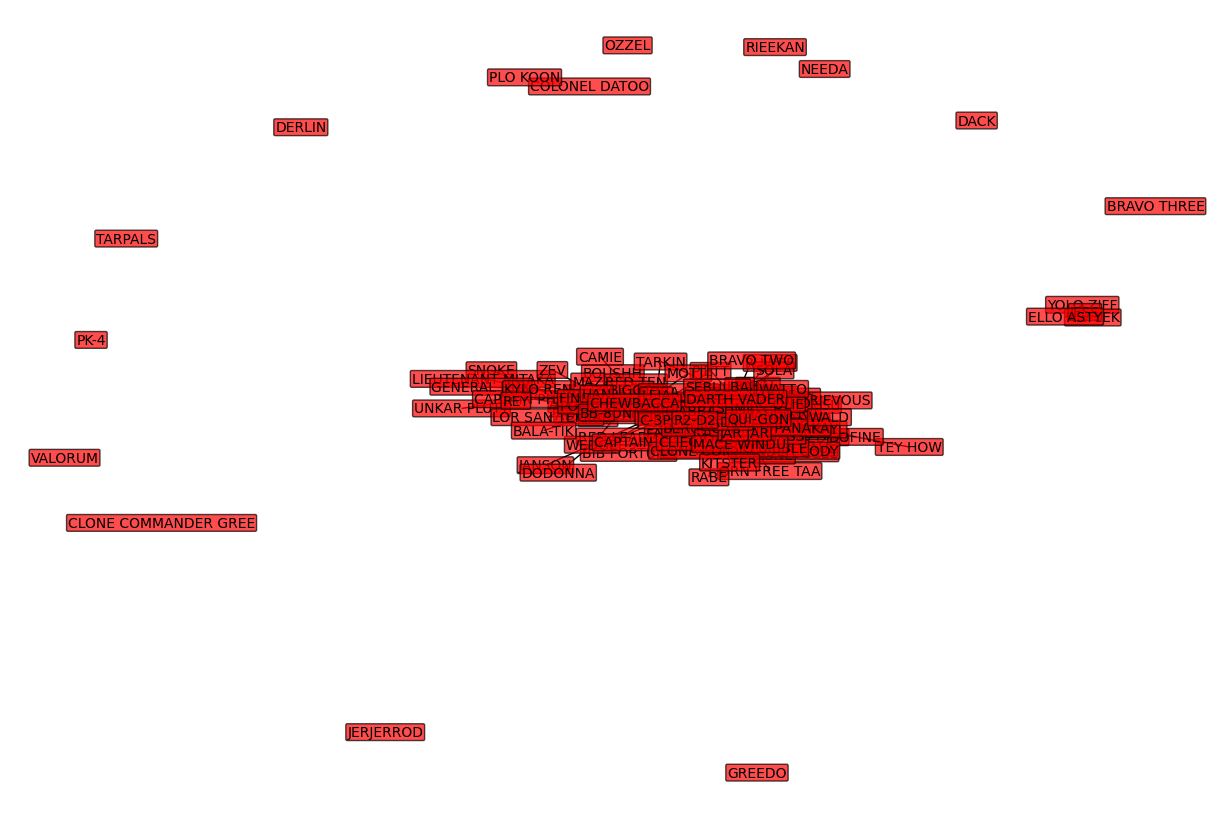

In [11]:
g50 = remove_edges_uniformly_at_random(g, 0.50)
plot_graph(g50)

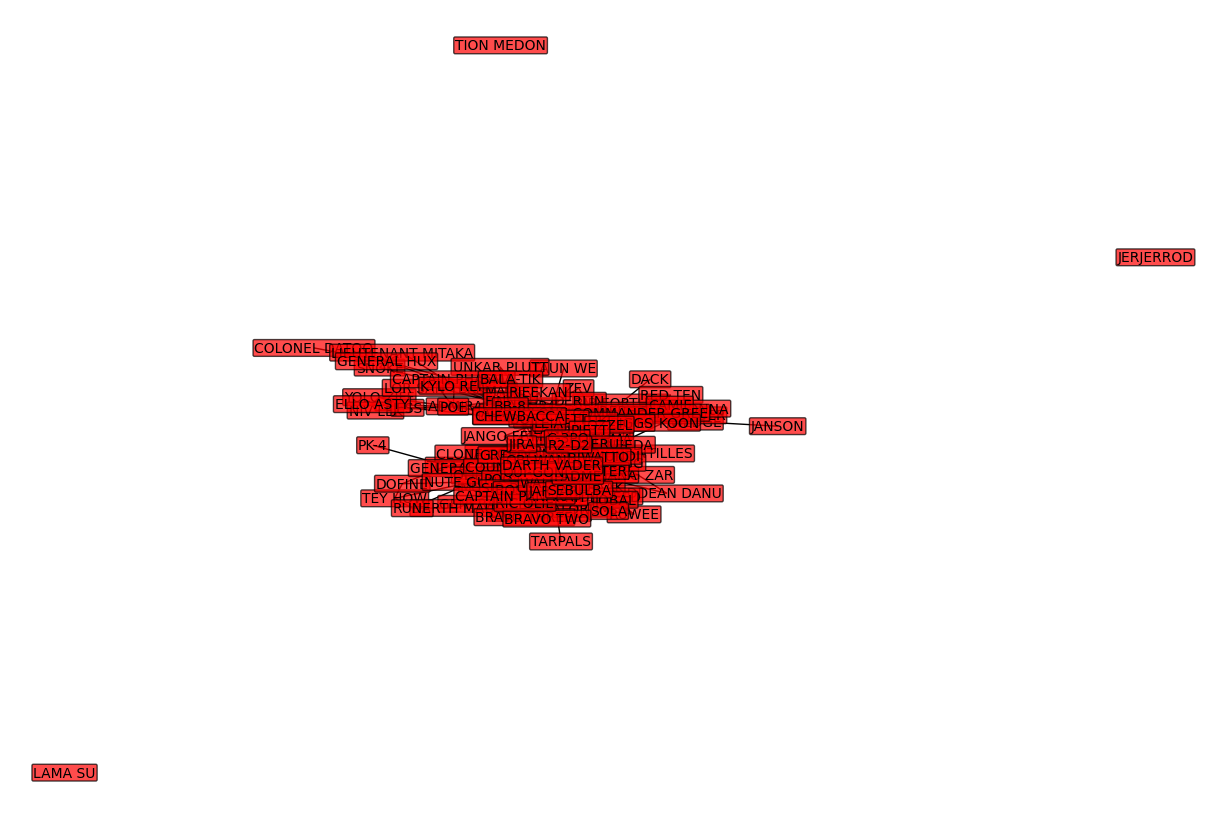

In [12]:
g85 = remove_edges_uniformly_at_random(g, 0.15)
plot_graph(g85)

In [13]:
def remove_edges_by_betweenness(g_in, p):
    # Check input is within bounds
    if p < 0.0 or p > 1.0:
        raise ValueError

    # Create a copy of the input graph
    g_out = g_in.copy()

    # Compute edge betweenness
    edge_betweenness = nx.edge_betweenness_centrality(g_out)
    edges_by_betweenness = sorted(edge_betweenness.items(), key=lambda x: x[1], reverse=True)

    # Decide how many edges should be in the output graph
    target_num_edges = int((1.0-p) * g_in.number_of_edges())

    # While there are more edges than desired
    while g_out.number_of_edges() > target_num_edges:
        edge_to_remove, betweenness = edges_by_betweenness.pop(0)
        g_out.remove_edge(*edge_to_remove)

    # Return the resulting graph
    return g_out

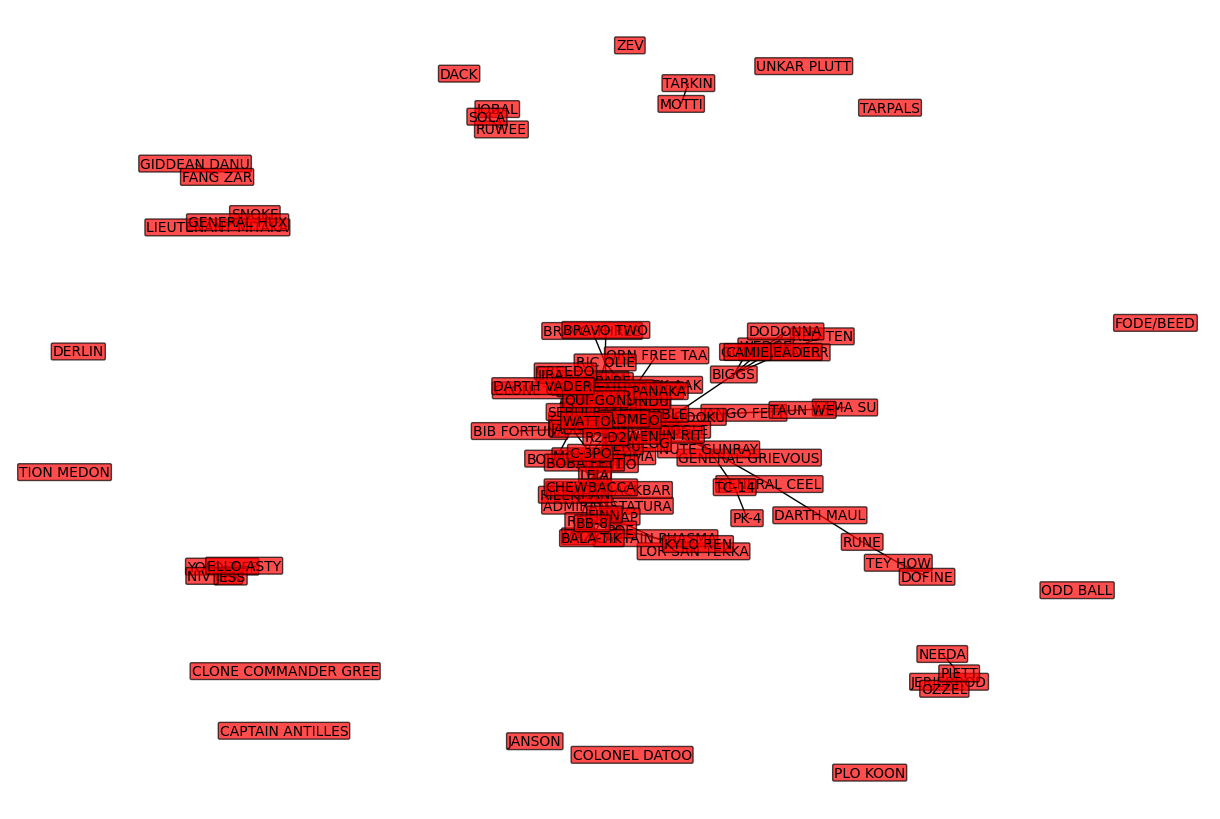

In [14]:
g50b = remove_edges_by_betweenness(g, 0.50)
plot_graph(g50b)

As expected, prioritizing the removal of edges with higher betweeness (meaning higher importance in terms of paths between nodes) broke the network into more connected components than just removing the edges randomly. This makes sense because betweeness is precisely a score of how many pairs of nodes rely (completely or partially) on that edge to be connected.

# 3. Assigning connected components

In [15]:
def assign_components(g):
    node2componentid = {}
    componentid = 1
    for node in g.nodes():
        if node not in node2componentid:
            assign_component_recursive(g, node2componentid, node, componentid)
            componentid += 1
    return node2componentid

def assign_component_recursive(g, node2componentid, starting_node, componentid):
    node2componentid[starting_node] = componentid
    for neighbor in g.neighbors(starting_node):
        if neighbor not in node2componentid:
            assign_component_recursive(g, node2componentid, neighbor, componentid)

In [16]:
# Test on cycle graph
cycle_components = assign_components(nx.cycle_graph(10))
for componentid in cycle_components.values():
    assert componentid == 1, "All nodes in cycle graph should belong to the same component, with ID 1."

# Test on caveman graph
caveman_components = assign_components(nx.caveman_graph(3, 3))
for componentid in caveman_components.values():
    assert componentid in [1, 2, 3], "Nodes in caveman graph should belong to one of three components (1, 2, or 3)."
    assert len([n for n, c in caveman_components.items() if c == componentid]) == 3, "There should be exactly 3 nodes assigned to each component in the caveman graph."

In [17]:
# Get component assignments of nodes using the function just defined
components_g50b = assign_components(g50b)

# Print component assignments
for character in ['LUKE', 'KYLO REN', 'SNOKE', 'PLO KOON'] :
    print(f"Character {character:<8} belongs to component {components_g50b[character]}")

Character LUKE     belongs to component 3
Character KYLO REN belongs to component 3
Character SNOKE    belongs to component 4
Character PLO KOON belongs to component 12


# 4. Number of connected components

In [18]:
def extract_connected_component_sizes(g):
    component_sizes = {} # create dict
    node2componentid = assign_components(g) # node -> component mapping
    for node, comp_id in node2componentid.items(): # count nodes per component
        if comp_id not in component_sizes:
            component_sizes[comp_id] = 0
        component_sizes[comp_id] += 1
    return component_sizes

component_sizes_g50b = extract_connected_component_sizes(g50b)

components_greater_than_1 = []
for comp_id, size in component_sizes_g50b.items(): # iterate through rows in component_sizes_g50b 
    if size > 1: #confirm size
        components_greater_than_1.append((comp_id, size)) # append as tuple

components_greater_than_1.sort(key=lambda x: x[1], reverse=True)
for component in components_greater_than_1:
    print("Id:", component[0], "   ", "Size:", component[1]) # print


Id: 3     Size: 79
Id: 1     Size: 4
Id: 4     Size: 3
Id: 18     Size: 3
Id: 21     Size: 3
Id: 11     Size: 2
Id: 19     Size: 2


In [19]:
def count_connected_components(g):
    node2componentid = assign_components(g)
    unique_components = set(node2componentid.values())
    return len(unique_components)

In [20]:
print(f"Number of connected components in graph g50b: {count_connected_components(g50b)}")

Number of connected components in graph g50b: 21


In [21]:
fraction_values = np.arange(0, 1, 0.02)
ncomponents_removing_uniformly_at_random_p = {}
ncomponents_removing_by_betweenness_p = {}

for p in fraction_values:
    g_uniform = remove_edges_uniformly_at_random(g, p)
    ncomponents_removing_uniformly_at_random_p[p] = count_connected_components(g_uniform)

    g_betweenness = remove_edges_by_betweenness(g, p)
    ncomponents_removing_by_betweenness_p[p] = count_connected_components(g_betweenness)


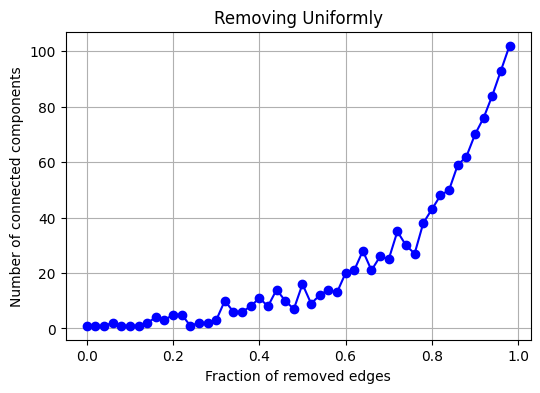

In [22]:
x = sorted(ncomponents_removing_uniformly_at_random_p.keys())
y = [ncomponents_removing_uniformly_at_random_p[p] for p in x]

plt.figure(figsize=(6,4))
plt.plot(x, y, marker='o', linestyle='-', color='blue')
plt.xlabel("Fraction of removed edges")
plt.ylabel("Number of connected components")
plt.title("Removing Uniformly")
plt.grid(True)
plt.show()

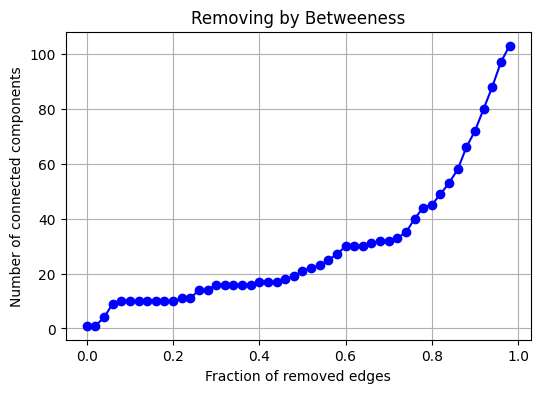

In [58]:
x = sorted(ncomponents_removing_by_betweenness_p.keys())
y = [ncomponents_removing_by_betweenness_p[p] for p in x]

plt.figure(figsize=(6,4))
plt.plot(x, y, marker='o', linestyle='-', color='blue')
plt.xlabel("Fraction of removed edges")
plt.ylabel("Number of connected components")
plt.title("Removing by Betweeness")
plt.grid(True)
plt.show()

In [23]:
n = 50

avg_ncomponents_removing_uniformly_at_random_p = {}
for p in fraction_values:
    sum_of_cc = 0
    for i in range(n):
        g_uniform = remove_edges_uniformly_at_random(g, p)
        sum_of_cc += count_connected_components(g_uniform)
    avg_ncomponents_removing_uniformly_at_random_p[p] = sum_of_cc // n

avg_ncomponents_removing_by_betweenness_p = {}
for p in fraction_values:
    sum_of_cc = 0
    for i in range(n):
        g_betweenness = remove_edges_by_betweenness(g, p)
        sum_of_cc += count_connected_components(g_betweenness)
    avg_ncomponents_removing_by_betweenness_p[p] = sum_of_cc // n

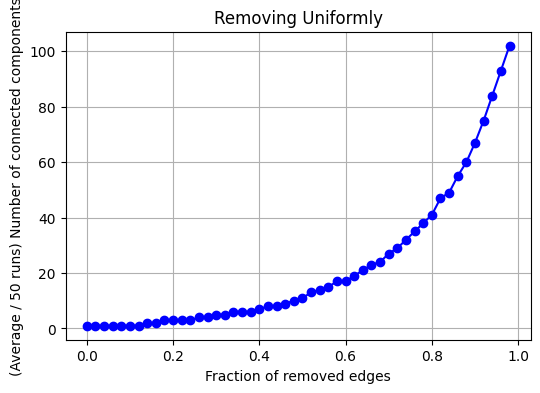

In [24]:
x = sorted(avg_ncomponents_removing_uniformly_at_random_p.keys())
y = [avg_ncomponents_removing_uniformly_at_random_p[p] for p in x]

plt.figure(figsize=(6,4))
plt.plot(x, y, marker='o', linestyle='-', color='blue')
plt.xlabel("Fraction of removed edges")
plt.ylabel("(Average / 50 runs) Number of connected components")
plt.title("Removing Uniformly")
plt.grid(True)
plt.show()

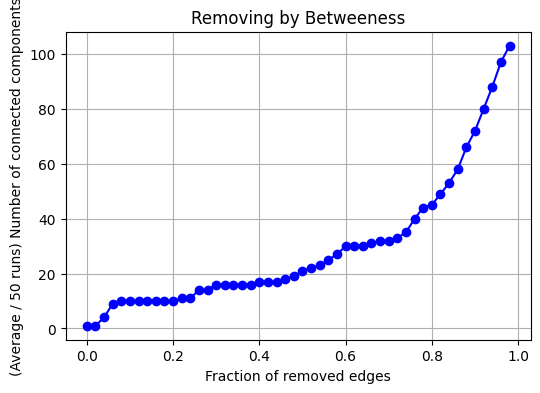

In [25]:
x = sorted(avg_ncomponents_removing_by_betweenness_p.keys())
y = [avg_ncomponents_removing_by_betweenness_p[p] for p in x]

plt.figure(figsize=(6,4))
plt.plot(x, y, marker='o', linestyle='-', color='blue')
plt.xlabel("Fraction of removed edges")
plt.ylabel("(Average / 50 runs) Number of connected components")
plt.title("Removing by Betweeness")
plt.grid(True)
plt.show()